In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import numpy as np
import pandas as pd
import os

root_dir = os.getcwd()

In [ ]:
# with conformer_id
def write_nw_file(nw_file, mol, basis="6-31G*", geometry="", calc_ESP=True, cid=0): 
    # Geometry Block of a Molecule
    if not geometry:
        conf = mol.GetConformer(cid)
        nAtom = mol.GetNumAtoms()
        for atomId in range(nAtom):
            atomType = mol.GetAtomWithIdx(atomId).GetSymbol()
            x, y, z = conf.GetAtomPosition(atomId)
            geometry += "\t{}\t{:<20}\t{:<20}\t{:<20}\n".format(atomType, str(x), str(y), str(z))
    
    try:
        label = mol.GetProp("Label")
    except Exception as e:
        label = nw_file.split('.')[0]
    
    with open(nw_file, "w+") as f:
        f.write("echo\n")
        f.write("title {}_{}_ESP_Calculation\n".format(label, cid))
        f.write("start {}_{}\n\n".format(label, cid))
        f.write("geometry\n")
        f.write(geometry)
        f.write("end\n\n")
        f.write("charge {}\n\n".format(mol.GetProp("Charge")))
        f.write("basis\n\t* library {}\nend\n\n".format(basis))
        f.write("driver\n\tmaxiter 100\n\txyz {}_{}\nend\n\n".format(label, cid))
        f.write("dft\n\txc b3lyp\n\tmaxiter 2000\nend\n")
        f.write("task dft optimize\n\n")
        if calc_ESP:
            f.write("esp\n\trecalculate\n\trange 0.2\n\tprobe 0.1\n\tspacing 0.025\nend\n")
            f.write("task esp")
    
    return True

In [ ]:
data = pd.read_csv("../Catalysts/catalysts_subs.csv")
smiles = data["smiles"]
labels = data["label"]
charges = data["charge"]
mols =[]
for smi, label, charge in zip(smiles, labels, charges):
    mol = Chem.MolFromSmiles(smi)
    mol.SetProp("Label", str(label))
    mol.SetProp("Charge", str(charge))
    mols.append(mol)

In [ ]:
for mol in mols:
    label = mol.GetProp("Label")
    path = os.path.join(root_dir, label)
    if not os.path.exists(path):
        os.mkdir(path)
    mol = Chem.AddHs(mol)
    
    # generate conformers
    AllChem.EmbedMultipleConfs(mol, numConfs=50)
    res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=0)
    confs = [(k, res[k][1]) for k in range(numConfs)]
    # sort with regard to energy
    confs.sort(key=lambda x: x[-1])
    AllChem.AlignMolConformers(mol)
    # select 3 conformers: conf with the least energy and the two confs with the highest rms to it
    tmp = []
    cid1, energy1 = confs[0]
    for i in range(1, numConfs):
        cid2, energy2 = confs[i]
        rms = AllChem.GetConformerRMS(mol, cid1, cid2, prealigned=True)
        tmp.append((cid2, rms))
    tmp.sort(key=lambda x: x[-1], reverse=True)

    select_cids = [x[0] for x in tmp[:3]]
    
    # write .nw file
    for cid in select_cids:
        write_nw_file(os.path.join(path, f"{label}_{cid}.nw"), mol, cid=cid)

In [ ]:
# Read .grid file
def read_grid_file(grid_file):
    try:
        with open(grid_file, 'r') as f:
            data = f.read().split("\n")[1:-1]

        esp = np.array([float(d.split()[-1]) for d in data])

        # Hatree(a.u.) -> kcal/mol
        esp = esp * 27.2114 * 1.6022e-19 * 6.022e23 / 4.1858518 / 1000
        
        print("Read file:", grid_file)
        return esp
    except Exception as e:
        print("Fail to read:", grid_file)

        
grid_files = {}
ESPMAX_res = {}
ESPMIN_res = {}
for label in labels:
    grid_files[label] = []
    ESPMAX_res[label] = []
    ESPMIN_res[label] = []
    path = os.path.join(root_dir, "Results", str(label))
    for root, dirs, files in os.walk(path):
        for file in files:
            if ".grid" in file and "checkpoint" not in file:
                grid_files[label].append(file)
                esp = read_grid_file(os.path.join(path, file))
                ESPMAX_res[label].append(esp.max())
                ESPMIN_res[label].append(esp.min())
ESPMAX_res

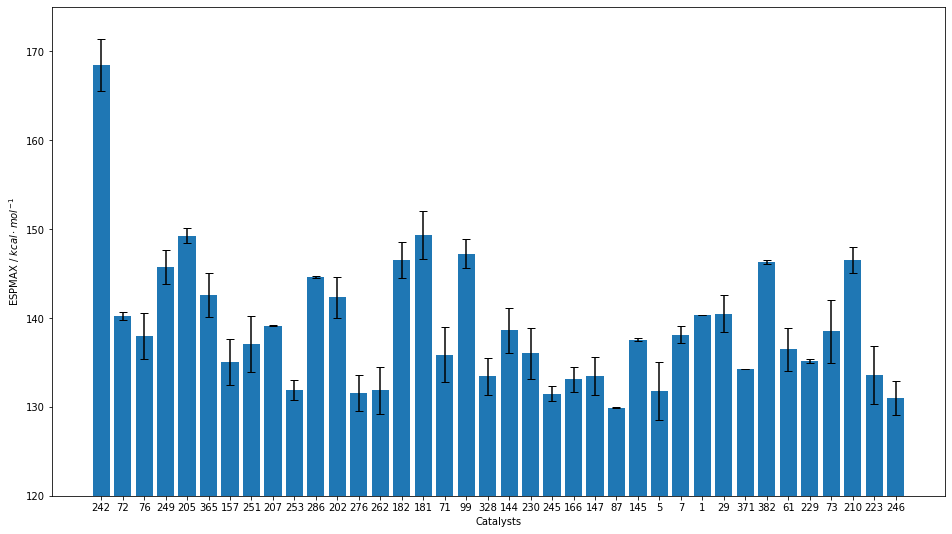

In [35]:
# Plot
import pandas as pd
import matplotlib.pyplot as plt

labels = list(ESPMAX_res.keys())
df = pd.DataFrame(ESPMAX_res)
std = df.apply(lambda x: x.std(), axis=0)
mean = df.apply(lambda x: x.mean(), axis=0)
index = np.arange(len(labels))
df.to_csv("Results.csv")

plt.figure(figsize=(16,9))
plt.xlabel("Catalysts")
plt.ylabel(r"ESPMAX / $kcal \cdot mol^{-1}$")
plt.bar(index, mean, yerr=std, error_kw={'capsize':4})
plt.xticks(index, labels)
plt.ylim(120, 175)
plt.savefig("Results.png", dpi=300)